<a href="https://colab.research.google.com/github/jlkbpl/Conformal/blob/main/margin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Margin error function - h = maxP(y) - P(true) 

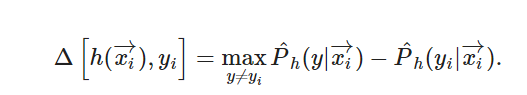

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

import matplotlib.pyplot as plt

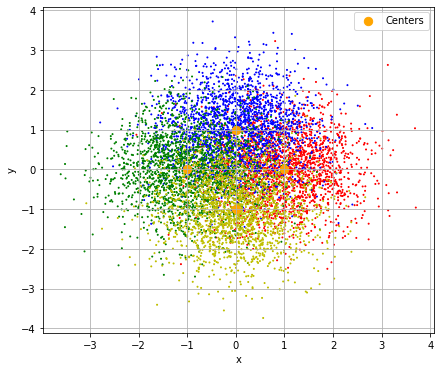

In [2]:
np.random.seed(20)
# centers of 4 classes
centers = [
    [ 1,  0],
    [ 0,  1],
    [-1,  0],
    [ 0, -1],
]

# colors to plot members of different classes
color_arr = ['r', 'b', 'g', 'y']

# number of instances per class
n_points = 2000
# these arrays will store information about datapoints
data_x = []
data_y = []
data_class = []
data_color = []

# standard deviation to generate the class instances
sigma = 0.8
# data generation
for class_val in range(0, len(centers)):
    x, y = centers[class_val]
    data_class.extend([class_val for j in range(0, n_points)])
    data_color.extend([color_arr[class_val] for j in range(0, n_points)])
    data_x.extend(np.random.normal(x, sigma, size=n_points))
    data_y.extend(np.random.normal(y, sigma, size=n_points))
# putting everything into a dataframe
data_df = pd.DataFrame({
    'x': data_x,
    'y': data_y,
    'class': data_class,
    'color': data_color,
})
# plotting the dataset
data_df.plot(
    kind='scatter',
    x='x',
    y='y',
    c=data_df['color'],
    s=1,
    grid=True,
    figsize=(7,6),
)

# showing the centers in orange
plt.scatter(np.array(centers).T[0], np.array(centers).T[1], s=70, c='orange', label='Centers')
plt.legend()
plt.show()

In [3]:
# fraction of the dataset to be used for testing
test_frac = 0.1
# fraction of the remaining dataset to be used for calibration
calib_frac = 0.2

np.random.seed(2)
# random permulation
idx = np.random.permutation(len(data_df))
# constucting test, training and calibration datasets
test_size = int(len(data_df) * test_frac) 
calib_size = int(len(data_df) * (1 - test_frac) * calib_frac)
train_size = len(data_df) - test_size - calib_size
idx_train, idx_cal, idx_test = idx[:train_size], idx[train_size:train_size + calib_size], idx[train_size + calib_size:]

print('Test size: {}'.format(test_size))
print('Calibration size: {}'.format(calib_size))
print('Train size: {}'.format(train_size))
model = SVC(probability=True)
model.fit(data_df[['x', 'y']].values[idx_train, :], data_df['class'].values[idx_train])


Test size: 800
Calibration size: 1440
Train size: 5760


SVC(probability=True)

In [4]:
# generating predictions for the calibration dataset
predictions_cal = model.predict_proba(X=data_df[['x', 'y']].values[idx_cal, :])
# extracting the predicted probability for the correct class labesl
calib_conformal_vals = []
max_prediction_cal_val = []
for i in range(0, len(idx_cal)):
    # correct class label
    cl = data_df['class'].values[idx_cal][i]
    # associated probability
    calib_conformal_vals.append(predictions_cal[i][cl])


In [5]:

def max_set_nonequaltrue(true_set,prediction_set):
#returns a list with max and non-true values
  max_pred_set=[]
  sorted_pred_set = np.sort(prediction_set)
  len_a, len_b = prediction_set.shape
  for i in range(0,len_a):
    for j in range(-1, -len_b-1, -1):
      if sorted_pred_set[i][j] != true_set[i]:
        max_pred_set.append(sorted_pred_set[i][j])
        break
      if sorted_pred_set[i][j] == true_set[i]:
        continue
  return max_pred_set


def margin_set(max_prediction_set, true_prediction_set):
  #takes a list with max values + a list with true labels
  margin_vals2 = []
  for i in range(0,len(max_prediction_set)):
    margin_vals2.append(0.5 - (true_prediction_set[i] - max_prediction_set[i] )/2 )
  return margin_vals2


In [12]:

max = max_set_nonequaltrue(calib_conformal_vals, predictions_cal)
margin = margin_set(max,calib_conformal_vals)
margin = np.array(margin)



Text(0.5, 1.0, 'Distribution of nonconformity values')

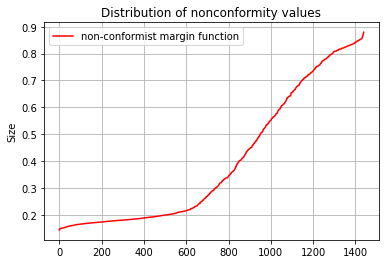

In [14]:
#plt.subplot(2,1,1)
plt.plot(np.sort(margin), color='r', label='margin-nonconf')

plt.legend(['non-conformist margin function'])
plt.grid(True)
plt.ylabel('Nonconformity value')
plt.ylabel('Size')
plt.title('Distribution of nonconformity values')
